This notebook presents a positional comparison of timing and Gaia+VLBI astrometric solutions, assuming that the misalignment between Gaia and VLBI celestial frames is much smaller than those between timing and Gaia or VLBI frames.

In all, I consider DE200, DE405, DE421, DE430, and DE436 in this notebook.

For the pulsar sample, I only use the non-MSP sample.

- Remove two pulsars (PSR J1435-6100 and PSR J1955+2908) that are most likely not ture associations for the Gaia pulsar sample and one pulsar (PSR J1546-5302) that does not have proper motion and parallax estimates in the Gaia EDR3.

- Remove all data points with offset greater than 1 arcsec in the absolute sense in either RA or Dec. Such a discrepancy is unlikely linked to the frame mis-alignment. **(2022-05-05)** 

- Remove PSRs near the Ecliptic plane, i.e., the ecliptic latitude is within $\pm\,5\,^{\circ}$. **(2022-06-10)** 

- Fix a serious bug in computing the RA offset and its uncertainty **(2022-08-13)**

In [1]:
from functools import reduce

import numpy as np
import seaborn as sns
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table, join, vstack
from astropy.time import Time
from matplotlib import pyplot as plt
from psrcrf_tools import *
from statsmodels.iolib.table import SimpleTable

/Users/Neo/Scisoft/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 1 Data preparation

Prepare the data for further analyses.

## 1.1 Load the database


### A) Gaia and timing solutions

Read the timing solution data.

In [2]:
timing_table = Table.read(
    "../data/timing_edr3.fits",
)
timing_table.sort("psr_name")

Remove two pulsars (PSR J1435-6100 and PSR J1955+2908) that are most likely not ture associations and one pulsar (PSR J1546-5302) that does not have proper motion and parallax estimates in the *Gaia* EDR3.

In [3]:
mask = (
    (timing_table["psr_name"] != "J1435-6100")
    & (timing_table["psr_name"] != "J1955+2908")
    & (timing_table["psr_name"] != "J1546-5302")
)
timing_table = Table(timing_table[mask], masked=False)

Add unit information

In [4]:
timing_table["ra"].unit = u.deg
timing_table["dec"].unit = u.deg
timing_table["pmra"].unit = u.mas / u.yr
timing_table["pmdec"].unit = u.mas / u.yr
timing_table["plx"].unit = u.mas
timing_table["ra_err"].unit = u.mas
timing_table["dec_err"].unit = u.mas
timing_table["pmra_err"].unit = u.mas / u.yr
timing_table["pmdec_err"].unit = u.mas / u.yr
timing_table["plx_err"].unit = u.mas

Load the cross-match table.

In [5]:
# edr3_antf_table = Table.read("../data/edr3_psrcatv1.65.fits")
# edr3_antf_table = Table.read("../data/edr3_psrcatv1.66.fits")
edr3_antf_table = Table.read("../data/edr3_psrcatv1.67.fits")

Find millisecond pulsars (MSPs) using the classification provided in J. Antoiniadis (2021).

In [6]:
B_over_G = 3.2e19 * np.sqrt(edr3_antf_table["p0"] * edr3_antf_table["p1"])

mask = (B_over_G <= 1e10)
msp_list = edr3_antf_table["name"][mask]

Only keep the astrometric parameters from Gaia.

In [7]:
edr3_antf_table = edr3_antf_table[
    "name",
    "source_id",
    "ra",
    "ra_error",
    "dec",
    "dec_error",
    "parallax",
    "parallax_error",
    "pmra",
    "pmra_error",
    "pmdec",
    "pmdec_error",
]

edr3_antf_table.rename_columns(
    [
        "name",
        "ra_error",
        "dec_error",
        "parallax",
        "parallax_error",
        "pmra_error",
        "pmdec_error",
    ],
    ["psr_name", "ra_err", "dec_err", "plx", "plx_err", "pmra_err", "pmdec_err"],
)

Add unit information

In [8]:
edr3_antf_table["ra"].unit = u.deg
edr3_antf_table["dec"].unit = u.deg
edr3_antf_table["pmra"].unit = u.mas / u.yr
edr3_antf_table["pmdec"].unit = u.mas / u.yr
edr3_antf_table["plx"].unit = u.mas
edr3_antf_table["ra_err"].unit = u.mas
edr3_antf_table["dec_err"].unit = u.mas
edr3_antf_table["pmra_err"].unit = u.mas / u.yr
edr3_antf_table["pmdec_err"].unit = u.mas / u.yr
edr3_antf_table["plx_err"].unit = u.mas

Only consider the young pulsars in the data.

In [9]:
for msp_name in msp_list:
    mask = ((timing_table["psr_name"] != msp_name))
    timing_table = Table(timing_table[mask], masked=False)

Supplement the timing table with the Gaia astrometric information.

In [10]:
edr3_timing = join(
    timing_table,
    edr3_antf_table,
    keys="psr_name",
    join_type="left",
    table_names=["t", "g"],
)

count_psr_nb(edr3_timing)

There are 17 pulsars with 22 measurements.


### B) VLBI and timing solutions

Read the timing solution data.

In [11]:
timing_table = Table.read(
    "../data/timing_vlbi.fits",
)

timing_table["ra"].unit = u.deg
timing_table["dec"].unit = u.deg
timing_table["pmra"].unit = u.mas / u.yr
timing_table["pmdec"].unit = u.mas / u.yr
timing_table["plx"].unit = u.mas
timing_table["ra_err"].unit = u.mas
timing_table["dec_err"].unit = u.mas
timing_table["pmra_err"].unit = u.mas / u.yr
timing_table["pmdec_err"].unit = u.mas / u.yr
timing_table["plx_err"].unit = u.mas

In [12]:
msp_list = ["J1022+1001", "J2010-1323",
            "J2145-0750", "J2317+1439", "J1012+5307", "J1537+1155"]

In [13]:
for msp_name in msp_list:
    mask = ((timing_table["psr_name"] != msp_name))
    timing_table = Table(timing_table[mask], masked=False)

Load PSRPI solution.

In [14]:
vlbi_table = Table.read("../data/psrpi.dat", format="ascii")

vlbi_table["ra"].unit = u.deg
vlbi_table["dec"].unit = u.deg
vlbi_table["pmra"].unit = u.mas / u.yr
vlbi_table["pmdec"].unit = u.mas / u.yr
vlbi_table["plx"].unit = u.mas
vlbi_table["ra_err"].unit = u.mas
vlbi_table["dec_err"].unit = u.mas
vlbi_table["pmra_err"].unit = u.mas / u.yr
vlbi_table["pmdec_err"].unit = u.mas / u.yr
vlbi_table["plx_err"].unit = u.mas

Join these two solutions.

In [15]:
vlbi_timing = join(
    timing_table, vlbi_table, keys="psr_name", join_type="left", table_names=["t", "g"]
)

vlbi_timing.rename_column("pos_epoch_t", "pos_epoch")

count_psr_nb(vlbi_timing)

There are 56 pulsars with 175 measurements.


## 1.2 Compute offsets between pulsar positions from timing and Gaia

Propagate the Gaia EDR3 position from J2016.0 to the timing positonal epoch and compute the positional offset,
in the sense of timing minus Gaia.

In [16]:
gaia_epoch = Time("2016.0", format="jyear").mjd
# 57388.5

# Epoch difference in Julian year
dt_y = (edr3_timing["pos_epoch"].value - gaia_epoch) / 365.25 * u.yr

# Cos(decl.) factor for the difference in R.A.
dec_fac = cos(np.deg2rad(edr3_timing["dec_g"].value))

dra = (
    edr3_timing["ra_t"] - edr3_timing["ra_g"]
) * dec_fac - dt_y * edr3_timing["pmra_g"]

ddec = edr3_timing["dec_t"] - edr3_timing["dec_g"] - \
    dt_y * edr3_timing["pmdec_g"]

dra = dra.to(u.mas)
ddec = ddec.to(u.mas)

edr3_timing.add_columns([dra, ddec], names=["dra", "ddec"])

In [17]:
edr3_timing["ra_err_t"] = edr3_timing["ra_err_t"] * dec_fac

dra_err = np.sqrt(
    edr3_timing["ra_err_g"] ** 2
    + edr3_timing["ra_err_t"] ** 2
    + (dt_y * edr3_timing["pmra_err_g"]).value ** 2
)

ddec_err = np.sqrt(
    edr3_timing["dec_err_g"] ** 2
    + edr3_timing["dec_err_t"] ** 2
    + (dt_y * edr3_timing["pmdec_err_g"]).value ** 2
)

edr3_timing.add_columns([dra_err, ddec_err], names=["dra_err", "ddec_err"])

Propagate the VLBI position from its epoch to the timing positonal epoch and compute the positional offset,
in the sense of timing minus VLBI.

In [18]:
# Epoch difference in Julian year
dt_y = (vlbi_timing["pos_epoch"].value -
        vlbi_timing["pos_epoch_g"]) / 365.25 * u.yr

# Cos(decl.) factor for the difference in R.A.
dec_fac = cos(np.deg2rad(vlbi_timing["dec_g"].value))

dra = (
    vlbi_timing["ra_t"] - vlbi_timing["ra_g"]
) * dec_fac - dt_y * vlbi_timing["pmra_g"]

ddec = vlbi_timing["dec_t"] - vlbi_timing["dec_g"] - \
    dt_y * vlbi_timing["pmdec_g"]

dra = dra.to(u.mas)
ddec = ddec.to(u.mas)

vlbi_timing.add_columns([dra, ddec], names=["dra", "ddec"])

In [19]:
vlbi_timing["ra_err_t"] = vlbi_timing["ra_err_t"] * dec_fac

dra_err = np.sqrt(
    vlbi_timing["ra_err_g"] ** 2
    + vlbi_timing["ra_err_t"] ** 2
    + (dt_y * vlbi_timing["pmra_err_g"]).value ** 2
)

ddec_err = np.sqrt(
    vlbi_timing["dec_err_g"] ** 2
    + vlbi_timing["dec_err_t"] ** 2
    + (dt_y * vlbi_timing["pmdec_err_g"]).value ** 2
)

vlbi_timing.add_columns([dra_err, ddec_err], names=["dra_err", "ddec_err"])

Join the Gaia-timing and VLBI-timing tables.

In [20]:
gv_timing = vstack((edr3_timing, vlbi_timing))

In [21]:
count_psr_nb(gv_timing)

There are 72 pulsars with 197 measurements.


## 1.3 Plot the sky distribution

Find pulsars according to the underlying reference frames the time positions are referring to.

In [22]:
mask = gv_timing["eph"] == "DE200"
gv_timing200 = gv_timing[mask]

mask = gv_timing["eph"] == "DE405"
gv_timing405 = gv_timing[mask]

mask = gv_timing["eph"] == "DE421"
gv_timing421 = gv_timing[mask]

mask = gv_timing["eph"] == "DE430"
gv_timing430 = gv_timing[mask]

mask = gv_timing["eph"] == "DE436"
gv_timing436 = gv_timing[mask]

I plot the distribution for all pulsars in one figure.

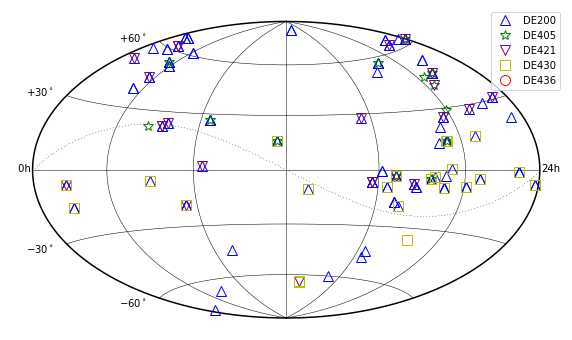

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis("off")

# Uniform sampling in longtitude and latitude
lon_arr = np.arange(0, 361, 5)
lat_arr = np.arange(-90, 91, 1)

# Plot a ellipse border.
lon_bords = np.array([0, 360])

# A loop to plot 7 grid.
for lon_bord in lon_bords:
    lat = lat_arr
    lon = np.ones_like(lat) * lon_bord
    X, Y = hammer_projection(lon, lat)
    ax.plot(X, Y, "k", linewidth=1.5)

# Grid plot.
# longtitude_grid_plot()
# 6 nodes in the longtitude from 0 to 360 deg.
lon_nodes = np.arange(60, 360, 60)

# A loop to plot 7 grid.
for lon_node in lon_nodes:
    lat = lat_arr
    lon = np.ones_like(lat) * lon_node
    X, Y = hammer_projection(lon, lat)
    ax.plot(X, Y, "k", linewidth=0.5)

# latitude_grid_plot()
# 5 nodes in the latitude from -60 to +60 deg.
lat_nodes = np.arange(-60, 61, 30)

# A loop to plot 7 grid.
for lat_node in lat_nodes:
    lon = lon_arr
    lat = np.ones_like(lon) * lat_node
    X, Y = hammer_projection(lon, lat)
    ax.plot(X, Y, "k", linewidth=0.5)

# Grid tickers.
# For fundamental plane.
lon0 = np.array([0, 360])
lat0 = np.array([0, 0])
X0, Y0 = hammer_projection(lon0, lat0)

ax.text(X0[0] - 0.2, Y0[0] - 0.025, " 0h")
ax.text(X0[1] + 0.02, Y0[1] - 0.025, "24h")

# For latitude grid
lon = np.array([0, 0])
lat = np.array([30, 60])
X, Y = hammer_projection(lon, lat)

for i in range(lat.size):
    ax.text(X[i] - 0.45, Y[i] - 0.0, "$+%d^\circ$" % lat[i])
    ax.text(X[i] - 0.45, -Y[i] - 0.1, "$-%d^\circ$" % lat[i])

# Plot the source.
shift = 0.025
# DE200
X, Y = hammer_projection(gv_timing200["ra_g"], gv_timing200["dec_g"])
ax.plot(X, Y, "^", mfc="none", mec="b", ms=10, label="DE200")

# DE405
X, Y = hammer_projection(gv_timing405["ra_g"], gv_timing405["dec_g"])
ax.plot(X, Y, "*", mfc="none", mec="g", ms=10, label="DE405")

# DE421
X, Y = hammer_projection(gv_timing421["ra_g"], gv_timing421["dec_g"])
ax.plot(X, Y, "v", mfc="none", mec="purple", ms=10, label="DE421")

# DE430
X, Y = hammer_projection(gv_timing430["ra_g"], gv_timing430["dec_g"])
ax.plot(X, Y, "s", mfc="none", mec="y", ms=10, label="DE430")

# DE436
X, Y = hammer_projection(gv_timing436["ra_g"], gv_timing436["dec_g"])
ax.plot(X, Y, "o", mfc="none", mec="r", ms=10, label="DE436")

# Ecliptic plane
lon_arr = np.arange(0, 361, 2)
lat_arr = np.zeros_like(lon_arr)
ecl_plane = SkyCoord(lon_arr, lat_arr, unit="deg",
                     frame="barycentricmeanecliptic")
ecl_plane_equ = ecl_plane.icrs
ecl_ra = ecl_plane_equ.ra.value
ecl_dec = ecl_plane_equ.dec.value
X, Y = hammer_projection(ecl_ra, ecl_dec)
ax.plot(X, Y, ".", ms=0.5, color="grey")

ax.legend()

## 1.4 Compute statistics of position formal uncertainties

Compute the median positional formal uncertainties for each subset.

In [24]:
# For comparison of positional uncertainty
pos_err_tab = np.zeros((5, 6))

pos_err_tab[0, :] = calc_med_pos_err(gv_timing200)
pos_err_tab[1, :] = calc_med_pos_err(gv_timing405)
pos_err_tab[2, :] = calc_med_pos_err(gv_timing421)
pos_err_tab[3, :] = calc_med_pos_err(gv_timing430)
pos_err_tab[4, :] = calc_med_pos_err(gv_timing436)

/Users/Neo/Scisoft/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3430: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/Neo/Scisoft/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# 2 Compare timing and Gaia+VLBI positions

##  2.1 DE200 vs Gaia EDR3 + PSRpi

In [25]:
mask = gv_timing["eph"] == "DE200"
gv_timing200 = gv_timing[mask]

nb_psr_200 = len(gv_timing200.group_by("psr_name").groups)
nb_obs_200 = len(gv_timing200)

print("We have", nb_psr_200,
      "pulsars in the sample from DE200 vs. Gaia DR3 + PSRpi comparison with",
      nb_obs_200, "observations.")
# gv_timing200

We have 64 pulsars in the sample from DE200 vs. Gaia DR3 + PSRpi comparison with 122 observations.


/Users/Neo/Github/pulsar-crf-comparison/progs/psrcrf_tools.py:666: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


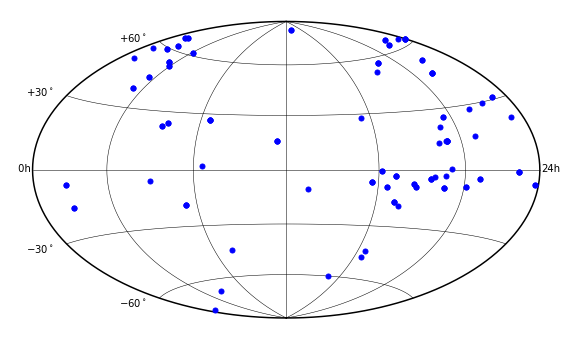

In [26]:
sou_dist_plot(
    gv_timing200["ra_g"],
    gv_timing200["dec_g"])

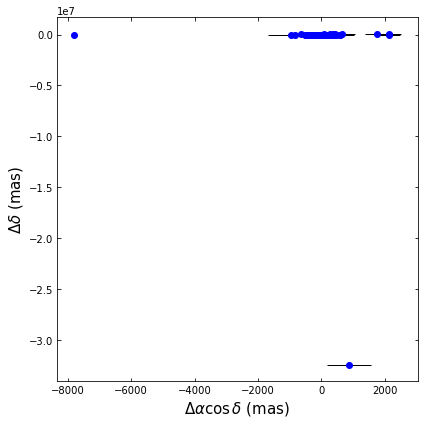

In [27]:
simple_plot(gv_timing200)

First, we check the positional offset visually.

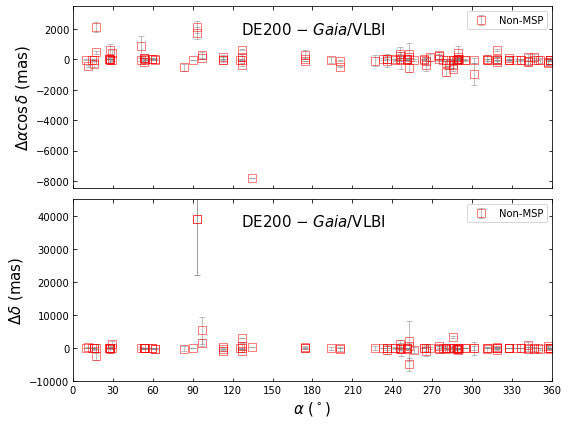

In [28]:
pos_oft_vs_coord(
    gv_timing200,
    [-8500, 3500, -10000, 45000],
    # Prefit
    gv_timing200["dra"],
    gv_timing200["ddec"],
    # Postfit
    #                  dra_200,
    #                  ddec_200,
    add_text=[0.35, 0.85, "DE200 $-$ $Gaia$/VLBI"],
    ref="g",
    xaxis="ra",
    divided=True)

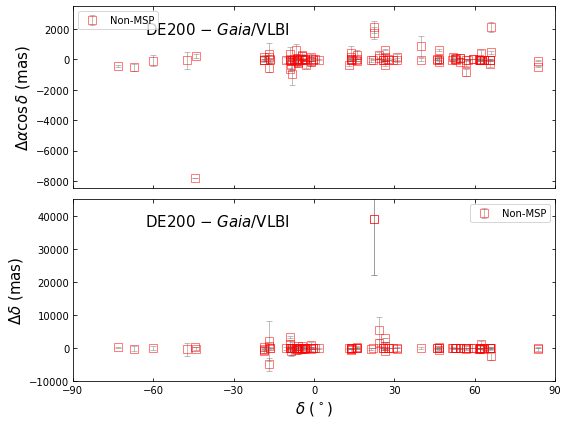

In [29]:
val_max = 1000
pos_oft_vs_coord(
    gv_timing200,
    [-8500, 3500, -10000, 45000],
    # Prefit
    gv_timing200["dra"],
    gv_timing200["ddec"],
    # Postfit
    #                  dra_200,
    #                  ddec_200,
    add_text=[0.15, 0.85, "DE200 $-$ $Gaia$/VLBI"],
    ref="g",
    xaxis="dec",
    divided=True)

Change the limits of the X- and Y-axes to remove the extremely large offsets. 

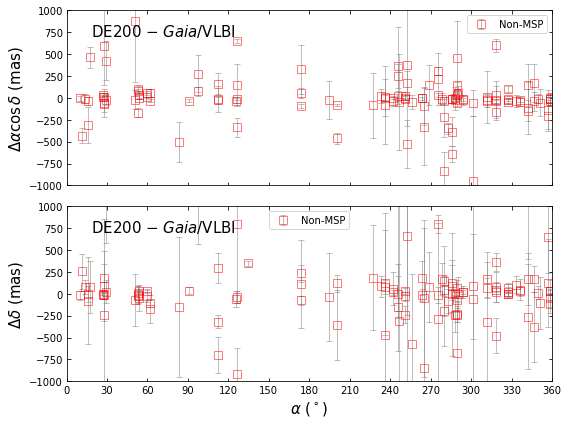

In [30]:
pos_oft_vs_coord(
    gv_timing200,
    [-1000, 1000, -1000, 1000],
    # Prefit
    gv_timing200["dra"],
    gv_timing200["ddec"],
    add_text=[0.05, 0.85, "DE200 $-$ $Gaia$/VLBI"],
    ref="g",
    xaxis="ra",
    divided=True)

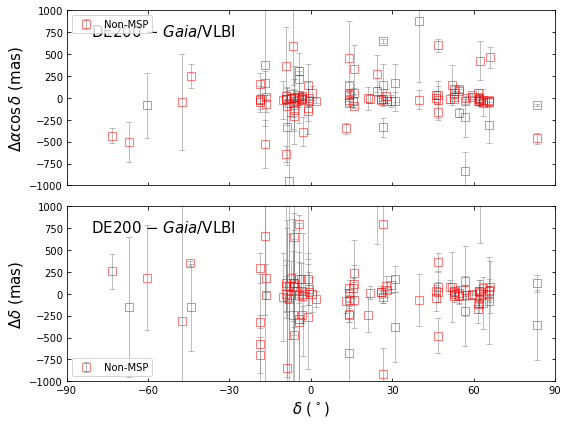

In [31]:
val_max = 1000
pos_oft_vs_coord(
    gv_timing200,
    [-1000, 1000, -1000, 1000],
    # Prefit
    gv_timing200["dra"],
    gv_timing200["ddec"],
    add_text=[0.05, 0.85, "DE200 $-$ $Gaia$/VLBI"],
    ref="g",
    xaxis="dec",
    divided=True)

## 2.2 DE405 vs Gaia EDR3

In [32]:
mask = gv_timing["eph"] == "DE405"
gv_timing405 = gv_timing[mask]

nb_psr_405 = len(gv_timing405.group_by("psr_name").groups)
nb_obs_405 = len(gv_timing405)

print("We have", nb_psr_405,
      "pulsars in the sample from DE405 vs. Gaia DR3 + PSRpi comparison with",
      nb_obs_405, "observations.")

# gv_timing405

We have 13 pulsars in the sample from DE405 vs. Gaia DR3 + PSRpi comparison with 13 observations.


Plot the sky distribution.

/Users/Neo/Github/pulsar-crf-comparison/progs/psrcrf_tools.py:666: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


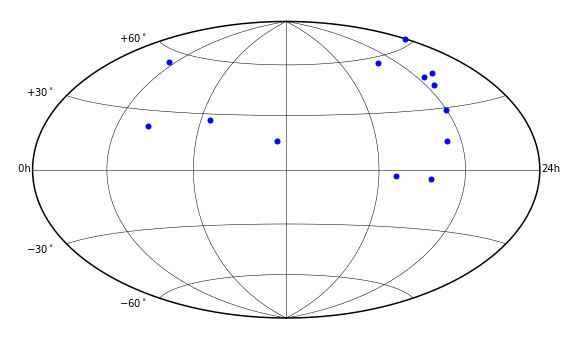

In [33]:
sou_dist_plot(gv_timing405["ra_g"], gv_timing405["dec_g"])

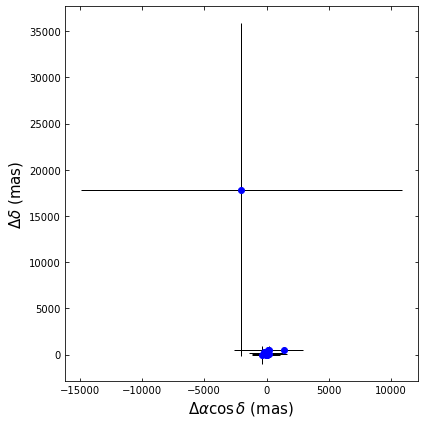

In [34]:
simple_plot(gv_timing405)

Plot the relationship between position offsets and RA/DEC.

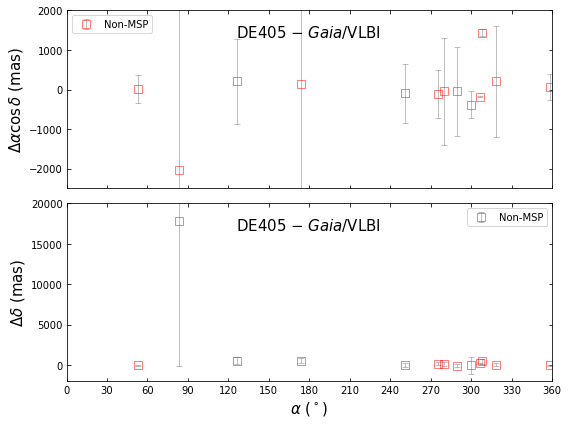

In [35]:
pos_oft_vs_coord(gv_timing405, [-2500, 2000, -2000, 20000],
                 gv_timing405["dra"],
                 gv_timing405["ddec"],
                 ref="g",
                 xaxis="ra",
                 add_text=[0.35, 0.85, "DE405 $-$ $Gaia$/VLBI"],
                 divided=True)

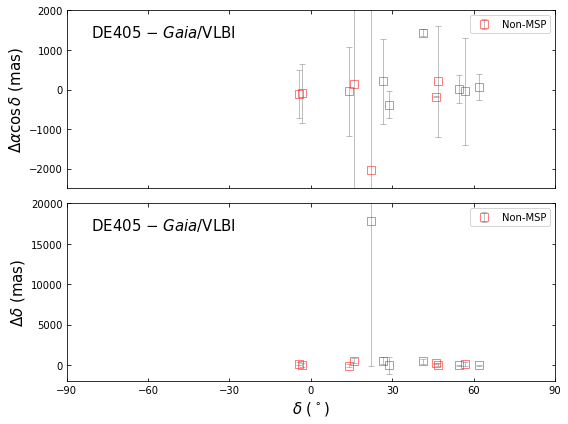

In [36]:
pos_oft_vs_coord(gv_timing405, [-2500, 2000, -2000, 20000],
                 gv_timing405["dra"],
                 gv_timing405["ddec"],
                 ref="g",
                 xaxis="dec",
                 add_text=[0.05, 0.85, "DE405 $-$ $Gaia$/VLBI"],
                 divided=True)

Change the limits of the X- and Y- axes.

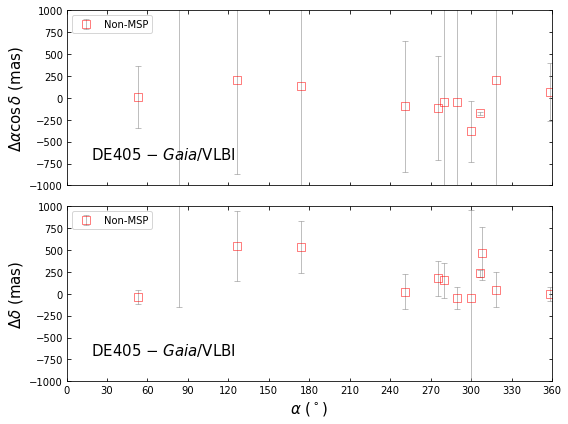

In [37]:
pos_oft_vs_coord(gv_timing405, [-1000, 1000, -1000, 1000],
                 gv_timing405["dra"],
                 gv_timing405["ddec"],
                 add_text=[0.05, 0.15, "DE405 $-$ $Gaia$/VLBI"],
                 ref="g",
                 xaxis="ra",
                 divided=True)

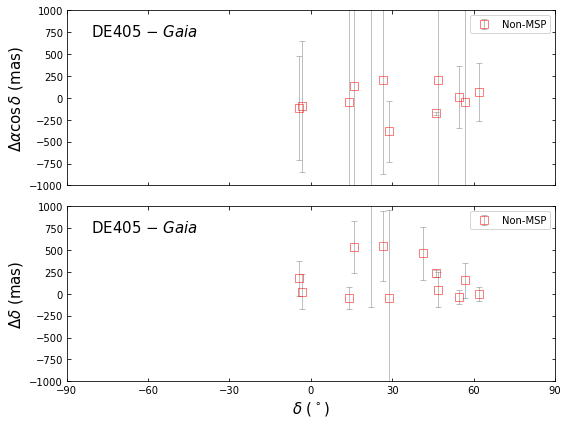

In [38]:
pos_oft_vs_coord(gv_timing405, [-1000, 1000, -1000, 1000],
                 gv_timing405["dra"],
                 gv_timing405["ddec"],
                 ref="g",
                 xaxis="dec",
                 add_text=[0.05, 0.85, "DE405 $-$ $Gaia$"],
                 divided=True)

## 2.3 DE421 vs Gaia EDR3

In [39]:
mask = gv_timing["eph"] == "DE421"
gv_timing421 = gv_timing[mask]

nb_psr_421 = len(gv_timing421.group_by("psr_name").groups)
nb_obs_421 = len(gv_timing421)

print("We have", nb_psr_421,
      "pulsars in the sample from DE421 vs. Gaia DR3 comparison with",
      nb_obs_421, "observations.")

We have 20 pulsars in the sample from DE421 vs. Gaia DR3 comparison with 23 observations.


/Users/Neo/Github/pulsar-crf-comparison/progs/psrcrf_tools.py:666: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


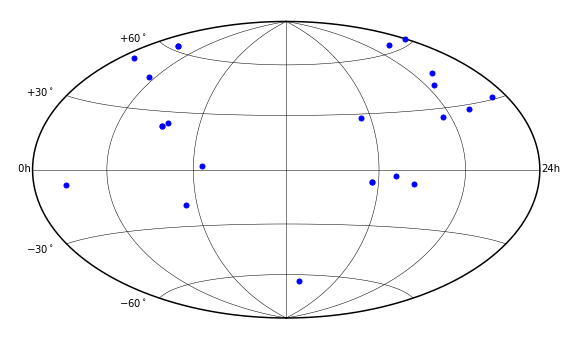

In [40]:
sou_dist_plot(gv_timing421["ra_g"], gv_timing421["dec_g"])

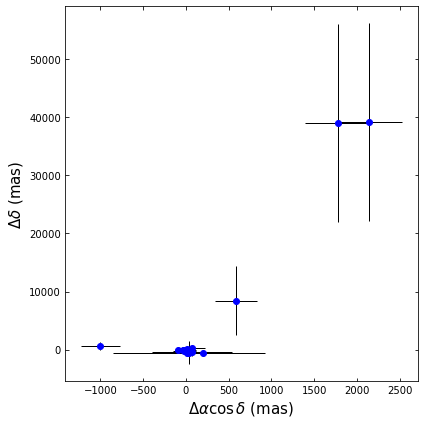

In [41]:
simple_plot(gv_timing421)

Obviously, there is one measurment is far from the other points.

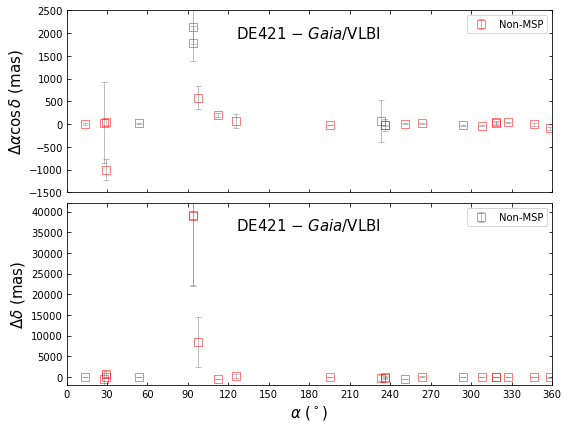

In [42]:
pos_oft_vs_coord(gv_timing421, [-1500, 2500, -2000, 42000],
                 gv_timing421["dra"],
                 gv_timing421["ddec"],
                 add_text=[0.35, 0.85, "DE421 $-$ $Gaia$/VLBI"],
                 ref="g",
                 xaxis="ra",
                 divided=True)

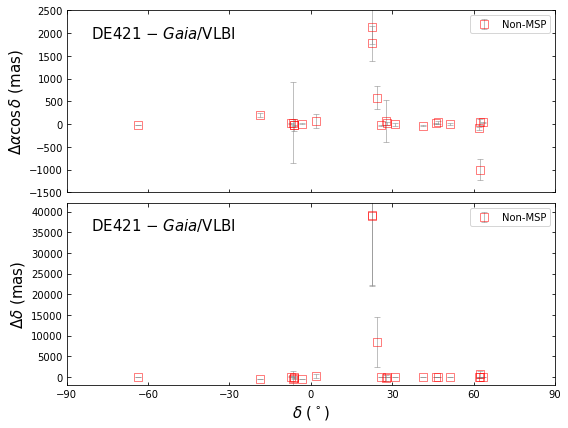

In [43]:
pos_oft_vs_coord(gv_timing421, [-1500, 2500, -2000, 42000],
                 gv_timing421["dra"],
                 gv_timing421["ddec"],
                 ref="g",
                 xaxis="dec",
                 add_text=[0.05, 0.85, "DE421 $-$ $Gaia$/VLBI"],
                 divided=True)

Shorten the limits of the X- and Y- axes.

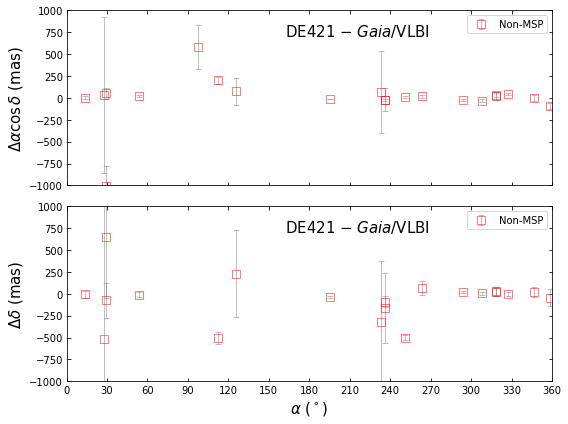

In [44]:
pos_oft_vs_coord(gv_timing421, [-1000, 1000, -1000, 1000],
                 gv_timing421["dra"],
                 gv_timing421["ddec"],
                 add_text=[0.45, 0.85, "DE421 $-$ $Gaia$/VLBI"],

                 ref="g",
                 xaxis="ra",
                 divided=True)

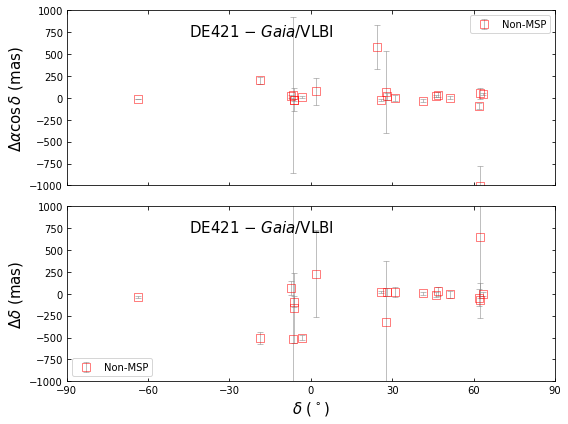

In [45]:
pos_oft_vs_coord(gv_timing421, [-1000, 1000, -1000, 1000],
                 gv_timing421["dra"],
                 gv_timing421["ddec"],
                 ref="g",
                 xaxis="dec",
                 add_text=[0.25, 0.85, "DE421 $-$ $Gaia$/VLBI"],

                 divided=True)

## 2.4 DE430 vs Gaia EDR3

In [46]:
mask = gv_timing["eph"] == "DE430"
gv_timing430 = gv_timing[mask]

nb_psr_430 = len(gv_timing430.group_by("psr_name").groups)
nb_obs_430 = len(gv_timing430)

# count_psr_nb(gv_timing430)
print("We have", nb_psr_430,
      "pulsars in the sample from DE430 vs. Gaia DR3 + PSRpi comparison with",
      nb_obs_430, "observations.")
# edr3_timing430

We have 23 pulsars in the sample from DE430 vs. Gaia DR3 + PSRpi comparison with 37 observations.


/Users/Neo/Github/pulsar-crf-comparison/progs/psrcrf_tools.py:666: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


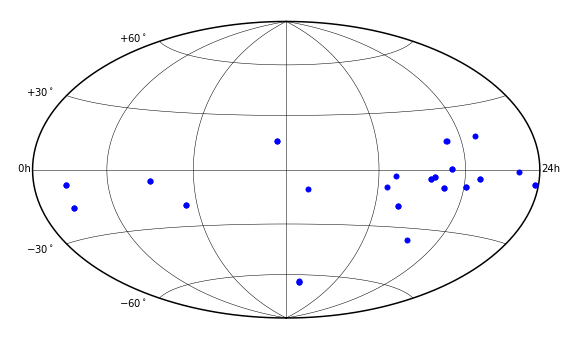

In [47]:
sou_dist_plot(
    gv_timing430["ra_g"],
    gv_timing430["dec_g"],
)

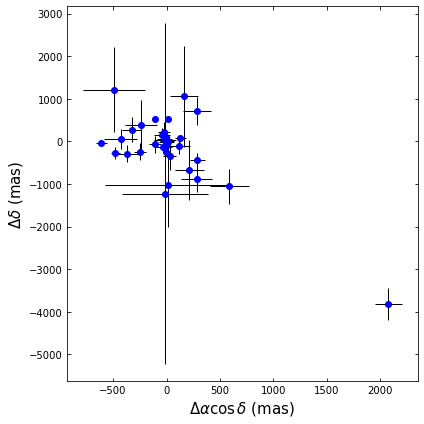

In [48]:
simple_plot(gv_timing430)

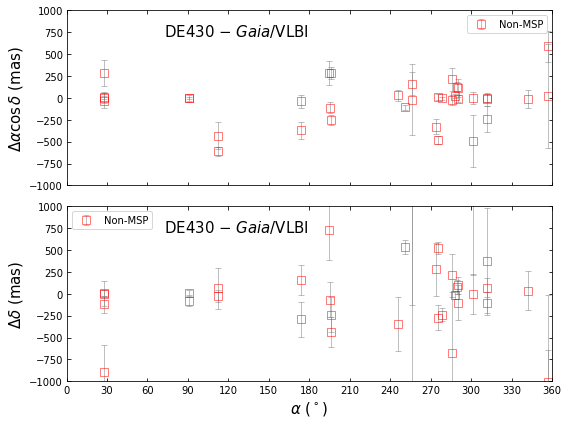

In [49]:
pos_oft_vs_coord(gv_timing430, [-1000, 1000, -1000, 1000],
                 gv_timing430["dra"],
                 gv_timing430["ddec"],
                 add_text=[0.2, 0.85, "DE430 $-$ $Gaia$/VLBI"],
                 ref="g",
                 xaxis="ra",
                 divided=True)

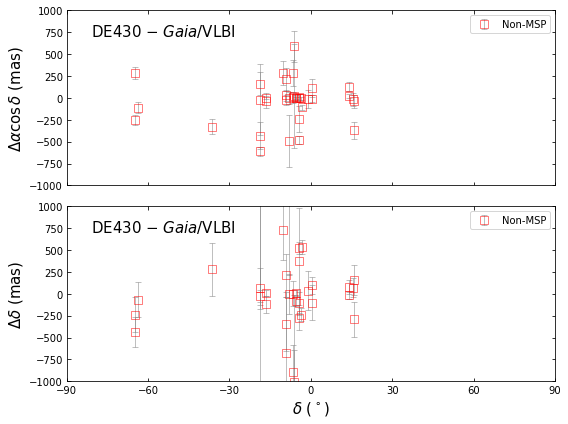

In [50]:
pos_oft_vs_coord(gv_timing430, [-1000, 1000, -1000, 1000],
                 gv_timing430["dra"],
                 gv_timing430["ddec"],
                 add_text=[0.05, 0.85, "DE430 $-$ $Gaia$/VLBI"],
                 ref="g",
                 xaxis="dec",
                 divided=True)

## 2.5 DE436 vs Gaia EDR3

In [51]:
# mask = gv_timing["eph"] == "DE436"
# gv_timing436 = gv_timing[mask]

# nb_psr_436 = len(gv_timing436.group_by("psr_name").groups)
# nb_obs_436 = len(gv_timing436)

# # count_psr_nb(gv_timing436)
# print("We have", nb_psr_436,
#       "pulsars in the sample from DE436 vs. Gaia DR3 comparison with",
#       nb_obs_436, "observations.")

# 3 Compare timing and Gaia/VLBI reference frames

## 3.1 Remove pulsars near the ecliptic plane

Remove PSRs near the Ecliptic plane within 10 degrees.

In [52]:
mask = (
    (gv_timing["psr_name"] != "J0614+2229")
    & (gv_timing["psr_name"] != "J0534+2200")
    & (gv_timing["psr_name"] != "J0337+1715")
    & (gv_timing["psr_name"] != "J2339-0533")
    #     & (gv_timing["psr_name"] != "J1723-2837")
    #     & (gv_timing["psr_name"] != "J2129-0429")
    #     & (gv_timing["psr_name"] != "J1023+0038")
    & (gv_timing["psr_name"] != "J0614+2229")
    & (gv_timing["psr_name"] != "J0629+2415")
    #     & (gv_timing["psr_name"] != "J0826+2637")
    & (gv_timing["psr_name"] != "J1022+1001")
    & (gv_timing["psr_name"] != "J1257-1027")
    #     & (gv_timing["psr_name"] != "J1650-1654")
    & (gv_timing["psr_name"] != "J1703-1846")
    #     & (gv_timing["psr_name"] != "J2010-1323")
    #     & (gv_timing["psr_name"] != "J2145-0750")
    #     & (gv_timing["psr_name"] != "J2248-0101")
    & (gv_timing["psr_name"] != "J2346-0609")
)
gv_timing = Table(gv_timing[mask], masked=False)

In [53]:
mask = gv_timing["eph"] == "DE200"
gv_timing200 = gv_timing[mask]

mask = gv_timing["eph"] == "DE405"
gv_timing405 = gv_timing[mask]

mask = gv_timing["eph"] == "DE421"
gv_timing421 = gv_timing[mask]

mask = gv_timing["eph"] == "DE430"
gv_timing430 = gv_timing[mask]

mask = gv_timing["eph"] == "DE436"
gv_timing436 = gv_timing[mask]

In [54]:
nb_psr_200 = len(gv_timing200.group_by("psr_name").groups)
nb_obs_200 = len(gv_timing200)

nb_psr_405 = len(gv_timing405.group_by("psr_name").groups)
nb_obs_405 = len(gv_timing405)

nb_psr_421 = len(gv_timing421.group_by("psr_name").groups)
nb_obs_421 = len(gv_timing421)

nb_psr_430 = len(gv_timing430.group_by("psr_name").groups)
nb_obs_430 = len(gv_timing430)

# nb_psr_436 = len(gv_timing436.group_by("psr_name").groups)
# nb_obs_436 = len(gv_timing436)

## 3.2 DE200 vs. Gaia + VLBI

Do the LSQ fitting iterately.

In [55]:
pmt200, sig200, indx, apr_chi2_200, pst_chi2_200 = rot_fit_4_table(
    gv_timing200)

rot200, iqr200 = find_pmt_est(pmt200)

Iter.  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  rmPSR  rmPSREpoch  rmPSRChi2
Unit: mas
 1 59 1447465.5 1447438.6      19.68    -219.10    -213.96 J0323+3944    48382 324013833.6
 2 59    997.8    946.6     183.84    -375.08    -174.53 J0857-4424    49080 196229.8
 3 58     16.1     16.0       6.70     -17.35       7.83 J0826+2637    51700   2621.6
 4 58      4.1      3.9     -14.99     -15.82     -10.13 J1901-0906    49901    120.6
 5 58      3.5      3.4     -13.99     -15.91      -8.93 J1820-0427    51700    112.3
 6 58      3.1      2.9     -13.63     -16.03     -10.48 J2113+4644    51700     85.9
 7 58      2.7      2.6     -12.34     -17.23     -11.06 J1321+8323    48383     56.2
 8 58      2.4      2.3     -10.18     -16.62     -10.03 J0108+6608    48464     51.0
 9 58      2.2      2.1      -9.88     -16.63     -10.01 J1321+8323    48889     21.6
10 57      2.1      2.0      -3.61     -15.33      -7.11 J1851+1259    49908     29.8
11 56      1.9      1.9      -3.22     -14.73    

104 10      0.1      0.1       1.66       8.48      -3.33 J1901-0906    50873      0.1
105  9      0.1      0.1       9.19       8.78       5.99 J2046-0421    49021      0.2
106  8      0.1      0.1       8.47       8.34       5.29 J1623-0908    48715      0.1
107  7      0.1      0.1      -7.19       8.24     -17.25 J1543-0620    46918      0.1
108  7      0.1      0.0      -6.94       8.48     -16.60 J1509-6015    51759      0.1
109  6      0.1      0.0      -5.97       7.59     -15.49 J0040+5716    49667      0.0
110  5      0.1      0.0      17.47      -8.37      -7.16 J0157+6212    49709      0.0
111  4      0.1      0.0     -62.15       2.28     -36.16 J0323+3944    49290      0.0
112  3      0.1      0.0     -34.88      -6.84     -22.36 J2317+2149    48716      0.0


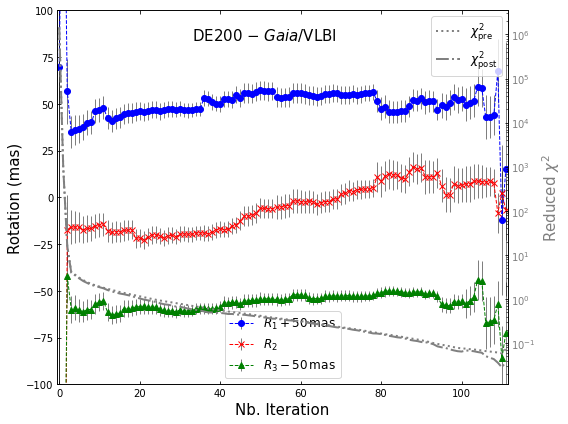

In [56]:
rot_vs_iter(pmt200,
            sig200, [-0.5, 111.5, -100, 100],
            elw=0.5,
            add_text=[0.3, 0.92, "DE200 $-$ $Gaia$/VLBI"],
            apr_chi2=apr_chi2_200,
            pst_chi2=pst_chi2_200,
            ax_loc="lower center",
            ax1_loc="upper right",
            y_shift=50, caps=0)

When removing these two PSRs, 

In [57]:
mask = ((np.fabs(gv_timing200["dra"]) < 1000)
        & (np.fabs(gv_timing200["ddec"]) < 1000)
        )

gv_timing200_a = gv_timing200[mask]

In [58]:
nb_psr_200 = len(gv_timing200_a.group_by("psr_name").groups)
nb_obs_200 = len(gv_timing200_a)

print("After removing outliers, we have", nb_psr_200,
      "pulsars in the sample from DE200 vs. Gaia DR3 + PSRpi comparison with",
      nb_obs_200, "observations.")

After removing outliers, we have 58 pulsars in the sample from DE200 vs. Gaia DR3 + PSRpi comparison with 104 observations.


and I do the LSQ fitting again.

In [59]:
pmt200_a, sig200_a, indx_a, apr_chi2_200_a, pst_chi2_200_a = rot_fit_4_table(
    gv_timing200_a)

rot200_a, iqr200_a = find_pmt_est(pmt200_a)

dra_200, ddec_200 = calc_dpos(gv_timing200, rot200_a)

a_chi2_200, p_chi2_200 = calc_chi2_4_fit(gv_timing200, dra_200, ddec_200)

Iter.  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  rmPSR  rmPSREpoch  rmPSRChi2
Unit: mas
 1 58      3.4      3.3     -13.61     -15.81      -8.85 J1820-0427    51700    112.3
 2 58      2.9      2.8     -13.25     -15.93     -10.40 J2113+4644    51700     86.0
 3 58      2.5      2.3     -11.97     -17.12     -10.98 J1321+8323    48383     56.3
 4 58      2.2      2.1      -9.80     -16.51      -9.95 J1321+8323    48889     21.7
 5 57      2.1      2.0      -3.52     -15.21      -7.04 J1851+1259    49908     29.8
 6 56      1.9      1.9      -3.12     -14.61      -5.91 J0045-7319    49144     25.3
 7 55      1.8      1.7      -1.96     -14.37      -5.27 J1917+1353    49763     30.2
 8 55      1.7      1.6      -7.59     -17.71     -11.30 J1917+1353    49021     24.4
 9 55      1.6      1.5      -8.91     -18.62     -12.94 J0729-1836    49720     18.5
10 55      1.5      1.4      -7.69     -18.20     -12.33 J0826+2637    48383     18.1
11 55      1.4      1.3      -7.12     -18.26     -11.

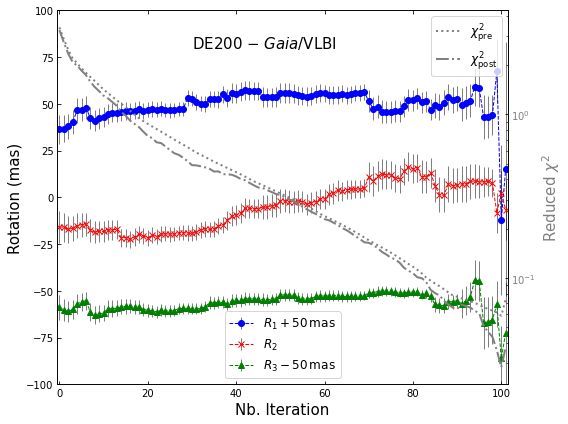

In [60]:
rot_vs_iter(
    pmt200_a,
    sig200_a,
    [-0.5, 101.5, -100, 100],
    elw=0.5,
    add_text=[0.3, 0.9, "DE200 $-$ $Gaia$/VLBI"],
    apr_chi2=apr_chi2_200_a,
    pst_chi2=pst_chi2_200_a,
    ax_loc="lower center",
    ax1_loc="upper right",
    y_shift=50, caps=0
)

In [61]:
print("Using all samples, the rotation parameters are")
print("R1:  {:6.0f} +/- {:6.0f} mas".format(rot200[0], iqr200[0]))
print("R2:  {:6.0f} +/- {:6.0f} mas".format(rot200[1], iqr200[2]))
print("R3:  {:6.0f} +/- {:6.0f} mas".format(rot200[2], iqr200[2]))

print("After removing J0857-4424, the rotation parameters are")
print("R1:  {:6.0f} +/- {:6.0f} mas".format(rot200_a[0], iqr200_a[0]))
print("R2:  {:6.0f} +/- {:6.0f} mas".format(rot200_a[1], iqr200_a[2]))
print("R3:  {:6.0f} +/- {:6.0f} mas".format(rot200_a[2], iqr200_a[2]))

Using all samples, the rotation parameters are
R1:       1 +/-      6 mas
R2:      -6 +/-      5 mas
R3:      -6 +/-      5 mas
After removing J0857-4424, the rotation parameters are
R1:       1 +/-      6 mas
R2:      -4 +/-      5 mas
R3:      -5 +/-      5 mas


## 3.3 DE405 vs Gaia+VLBI

In [62]:
pmt405, sig405, indx, apr_chi2_405, pst_chi2_405 = rot_fit_4_table(
    gv_timing405)

rot405, iqr405 = find_pmt_est(pmt405)

dra_405, ddec_405 = calc_dpos(gv_timing405, rot405)

a_chi2_405, p_chi2_405 = calc_chi2_4_fit(gv_timing405, dra_405, ddec_405)

Iter.  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  rmPSR  rmPSREpoch  rmPSRChi2
Unit: mas
 1 12     20.0     18.1    -123.46    -137.47     -64.39 J2032+4127    54938    319.7
 2 11      6.0      0.9    -163.07     -74.12    -293.18 J2027+4557    54250      2.1
 3 10      0.5      0.4     -29.62      33.93    -169.38 J1136+1551    52398      2.8
 4  9      0.4      0.3     -35.55      10.36    -174.12 J0826+2637    52398      2.2
 5  8      0.3      0.2     -50.03      -0.29    -198.01 J1958+2846    54800      0.4
 6  7      0.2      0.1     -47.20       4.97     -39.66 J1820-0427    52196      0.4
 7  6      0.1      0.1     -30.33       9.45       2.27 J1840+5640    52285      0.4
 8  5      0.1      0.1     -12.74      15.42      21.73 J0332+5434    52337      0.0
 9  4      0.1      0.1       9.46       4.91      41.58 J1917+1353    52298      0.1
10  3      0.1      0.0     -45.87       3.46       3.56 J2113+4644    52284      0.0


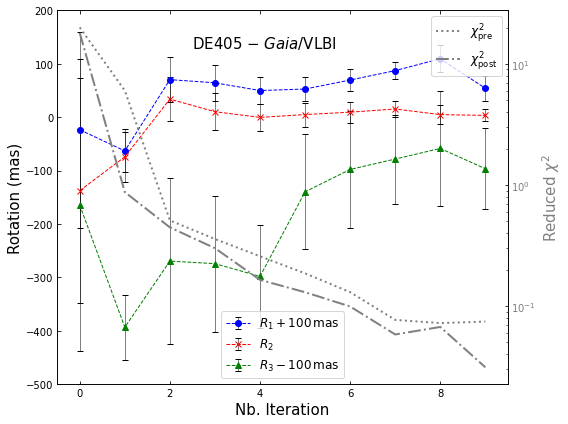

In [63]:
rot_vs_iter(
    pmt405,
    sig405,
    [-0.5, 9.5, -500, 200],
    add_text=[0.3, 0.9, "DE405 $-$ $Gaia$/VLBI"],
    apr_chi2=apr_chi2_405,
    pst_chi2=pst_chi2_405,
    ax_loc="lower center",
    ax1_loc="upper right",
    elw=0.5,
    y_shift=100
)

Let me try to remove some PSRs.

In [64]:
mask = (
    (np.fabs(gv_timing405["dra"]) < 1000)
    & (np.fabs(gv_timing405["ddec"]) < 1000)
)


gv_timing405_a = gv_timing405[mask]

In [65]:
nb_psr_405 = len(gv_timing405_a.group_by("psr_name").groups)
nb_obs_405 = len(gv_timing405_a)

print("After removing outliers, we have", nb_psr_405,
      "pulsars in the sample from DE405 vs. Gaia DR3 + PSRpi comparison with",
      nb_obs_405, "observations.")

After removing outliers, we have 11 pulsars in the sample from DE405 vs. Gaia DR3 + PSRpi comparison with 11 observations.


In [66]:
pmt405_a, sig405_a, indx, apr_chi2_405_a, pst_chi2_405_a = rot_fit_4_table(
    gv_timing405_a)

rot405_a, iqr405_a = find_pmt_est(pmt405_a)

dra_405_a, ddec_405_a = calc_dpos(gv_timing405_a, rot405_a)

a_chi2_405_a, p_chi2_405_a = calc_chi2_4_fit(
    gv_timing405_a, dra_405_a, ddec_405_a)

Iter.  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  rmPSR  rmPSREpoch  rmPSRChi2
Unit: mas
 1 11      6.0      0.9    -163.07     -74.12    -293.18 J2027+4557    54250      2.1
 2 10      0.5      0.4     -29.62      33.93    -169.38 J1136+1551    52398      2.8
 3  9      0.4      0.3     -35.55      10.36    -174.12 J0826+2637    52398      2.2
 4  8      0.3      0.2     -50.03      -0.29    -198.01 J1958+2846    54800      0.4
 5  7      0.2      0.1     -47.20       4.97     -39.66 J1820-0427    52196      0.4
 6  6      0.1      0.1     -30.33       9.45       2.27 J1840+5640    52285      0.4
 7  5      0.1      0.1     -12.74      15.42      21.73 J0332+5434    52337      0.0
 8  4      0.1      0.1       9.46       4.91      41.58 J1917+1353    52298      0.1
 9  3      0.1      0.0     -45.87       3.46       3.56 J2113+4644    52284      0.0


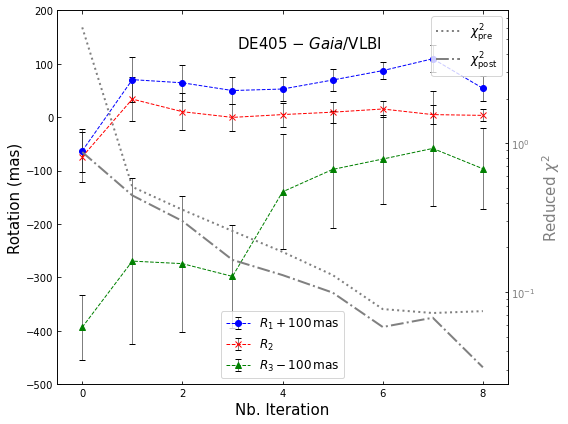

In [67]:
rot_vs_iter(
    pmt405_a,
    sig405_a,
    [-0.5, 8.5, -500, 200],
    add_text=[0.4, 0.9, "DE405 $-$ $Gaia$/VLBI"],
    xaxis_range=np.arange(0, 10, 2),
    apr_chi2=apr_chi2_405_a,
    pst_chi2=pst_chi2_405_a,
    ax_loc="lower center",
    ax1_loc="upper right",
    elw=0.5,
    y_shift=100
)

In [68]:
print("Using all samples, the rotation parameters are")
print("R1:  {:6.3f} +/- {:6.3f} mas".format(rot405[0], iqr405[0]))
print("R2:  {:6.3f} +/- {:6.3f} mas".format(rot405[1], iqr405[2]))
print("R3:  {:6.3f} +/- {:6.3f} mas".format(rot405[2], iqr405[2]))

print("After removing outliers, the rotation parameters are")
print("R1:  {:6.3f} +/- {:6.3f} mas".format(rot405_a[0], iqr405_a[0]))
print("R2:  {:6.3f} +/- {:6.3f} mas".format(rot405_a[1], iqr405_a[2]))
print("R3:  {:6.3f} +/- {:6.3f} mas".format(rot405_a[2], iqr405_a[2]))

Using all samples, the rotation parameters are
R1:  -40.711 +/- 14.464 mas
R2:   4.936 +/- 130.497 mas
R3:  -52.023 +/- 130.497 mas
After removing outliers, the rotation parameters are
R1:  -35.551 +/- 13.025 mas
R2:   4.967 +/- 131.614 mas
R3:  -39.656 +/- 131.614 mas


## 3.4 DE421 vs Gaia

In [69]:
pmt421, sig421, indx, apr_chi2_421, pst_chi2_421 = rot_fit_4_table(
    gv_timing421)

Iter.  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  rmPSR  rmPSREpoch  rmPSRChi2
Unit: mas
 1 18     13.1     12.3      18.56     -22.85      11.21 J1645-0317    56000    250.7
 2 17      5.7      5.4       6.60     -14.90       1.05 J0729-1836    56000     77.9
 3 16      3.6      3.3       6.57     -15.50      -1.33 J1302-6350    55000     12.1
 4 15      2.9      2.3     -28.11      -3.43      -6.54 J2149+6329    54595     11.2
 5 14      2.2      1.6      -3.18     -32.04      -5.08 J0157+6212    56000     20.6
 6 14      1.6      1.0      -3.98     -32.13      -5.10 J1937+2544    54248      0.4
 7 13      1.3      1.0       3.11     -27.94       0.97 J0335+4555    54596      1.7
 8 12      1.0      0.9      11.67     -18.26      -2.13 J2354+6155    56000      6.2
 9 11      0.8      0.7      -0.93     -16.92      -3.46 J1543-0620    54601      4.0
10 11      0.6      0.5       4.07     -20.70       9.11 J2032+4127    55700      2.5
11 10      0.4      0.3      -9.04       2.86      14.

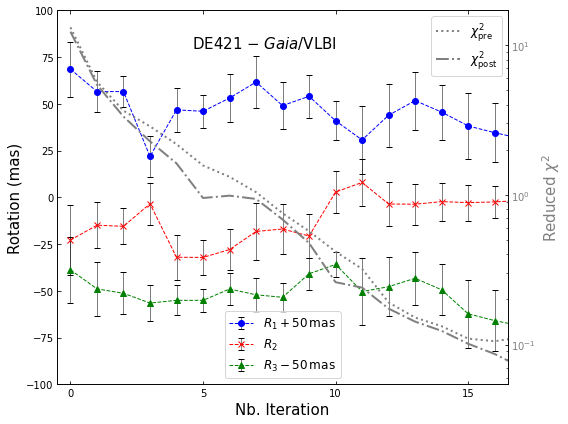

In [70]:
rot_vs_iter(
    pmt421,
    sig421,
    [-0.5, 16.5, -100, 100],
    xaxis_range=np.arange(0, 16, 5),
    add_text=[0.3, 0.9, "DE421 $-$ $Gaia$/VLBI"],
    apr_chi2=apr_chi2_421,
    pst_chi2=pst_chi2_421,
    ax_loc="lower center",
    ax1_loc="upper right",
    elw=0.5,
    y_shift=50
)

In [71]:
rot421, iqr421 = find_pmt_est(pmt421)

dra_421, ddec_421 = calc_dpos(gv_timing421, rot421)

a_chi2_421, p_chi2_421 = calc_chi2_4_fit(gv_timing421, dra_421, ddec_421)

In [72]:
mask = (
    (np.fabs(gv_timing421["dra"]) < 1000)
    & (np.fabs(gv_timing421["ddec"]) < 1000)
)


gv_timing421_a = gv_timing421[mask]

In [73]:
pmt421_a, sig421_a, indx, apr_chi2_421_a, pst_chi2_421_a = rot_fit_4_table(
    gv_timing421_a)

rot421_a, iqr421_a = find_pmt_est(pmt421_a)

Iter.  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  rmPSR  rmPSREpoch  rmPSRChi2
Unit: mas
 1 18     13.3     12.4      18.44     -22.97      11.23 J1645-0317    56000    250.8
 2 17      5.4      5.1       6.48     -15.02       1.08 J0729-1836    56000     77.9
 3 16      3.2      2.9       6.46     -15.62      -1.30 J1302-6350    55000     12.2
 4 15      2.4      1.7     -28.65      -3.70      -6.53 J2149+6329    54595     11.0
 5 14      1.6      1.0      -3.98     -32.13      -5.10 J1937+2544    54248      0.4
 6 13      1.3      1.0       3.11     -27.94       0.97 J0335+4555    54596      1.7
 7 12      1.0      0.9      11.67     -18.26      -2.13 J2354+6155    56000      6.2
 8 11      0.8      0.7      -0.93     -16.92      -3.46 J1543-0620    54601      4.0
 9 11      0.6      0.5       4.07     -20.70       9.11 J2032+4127    55700      2.5
10 10      0.4      0.3      -9.04       2.86      14.14 J1735-0724    54602      0.6
11  9      0.3      0.2     -19.29       7.97      -0.

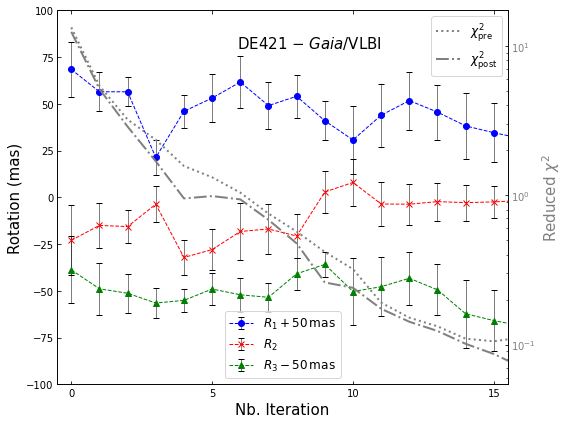

In [74]:
rot_vs_iter(
    pmt421_a,
    sig421_a,
    [-0.5, 15.5, -100, 100],
    add_text=[0.4, 0.9, "DE421 $-$ $Gaia$/VLBI"],
    xaxis_range=np.arange(0, 16, 5),
    apr_chi2=apr_chi2_421_a,
    pst_chi2=pst_chi2_421_a,
    ax_loc="lower center",
    ax1_loc="upper right",
    elw=0.5,
    y_shift=50
)

In [75]:
dra_421, ddec_421 = calc_dpos(gv_timing421, rot421_a)

a_chi2_421, p_chi2_421 = calc_chi2_4_fit(gv_timing421, dra_421, ddec_421)

In [76]:
print("Using all samples, the rotation parameters are")
print("R1:  {:6.3f} +/- {:6.3f} mas".format(rot421[0], iqr421[0]))
print("R2:  {:6.3f} +/- {:6.3f} mas".format(rot421[1], iqr421[2]))
print("R3:  {:6.3f} +/- {:6.3f} mas".format(rot421[2], iqr421[2]))

print("After removing outliers, the rotation parameters are")
print("R1:  {:6.3f} +/- {:6.3f} mas".format(rot421_a[0], iqr421_a[0]))
print("R2:  {:6.3f} +/- {:6.3f} mas".format(rot421_a[1], iqr421_a[2]))
print("R3:  {:6.3f} +/- {:6.3f} mas".format(rot421_a[2], iqr421_a[2]))

Using all samples, the rotation parameters are
R1:  -3.581 +/- 11.061 mas
R2:  -9.283 +/-  5.191 mas
R3:  -0.855 +/-  5.191 mas
After removing outliers, the rotation parameters are
R1:  -3.982 +/- 11.747 mas
R2:  -3.698 +/-  5.407 mas
R3:  -0.380 +/-  5.407 mas


## 3.5 DE430 vs Gaia

In [77]:
pmt430, sig430, indx, apr_chi2_430, pst_chi2_430 = rot_fit_4_table(
    gv_timing430)

rot430, iqr430 = find_pmt_est(pmt430)

Iter.  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  rmPSR  rmPSREpoch  rmPSRChi2
Unit: mas
 1 20     15.0     14.8     -11.04      29.88     -21.13 J1833-0338    57600    393.6
 2 20      8.8      8.5     -17.11      37.67     -27.30 J0729-1836    57600    122.6
 3 20      6.8      6.5     -24.98      74.21     -19.99 J1820-0427    57600    113.6
 4 20      4.8      4.6     -28.79      54.66      -8.16 J1645-0317    57600     47.5
 5 19      3.9      3.8     -10.94      27.96      -2.17 J1820-0427    57600     54.2
 6 18      2.9      2.8      15.95      32.02      -4.13 J1305-6455    57600     27.7
 7 18      2.5      2.3      29.25      53.69      -7.23 J1305-6455    57600     17.0
 8 17      2.1      2.0      10.31      45.39      -4.40 J1136+1551    57600     16.8
 9 17      1.8      1.8      13.08      48.90      -2.85 J1817-3618    57600     12.4
10 16      1.6      1.5      14.70      29.99      -0.14 J0151-0635    57600     12.0
11 16      1.4      1.3      16.00      23.36      -0.

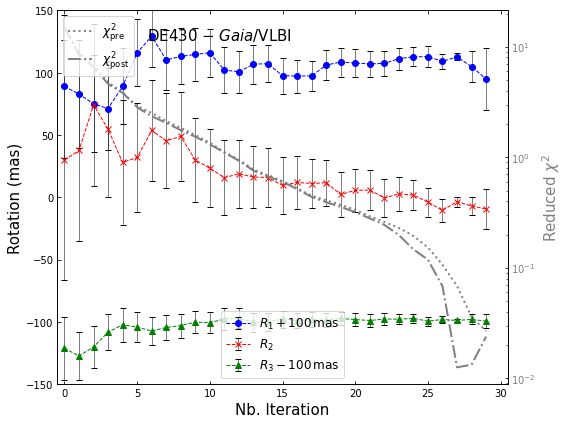

In [78]:
rot_vs_iter(
    pmt430,
    sig430,
    [-0.5, 30.5, -150, 150],
    apr_chi2=apr_chi2_430,
    pst_chi2=pst_chi2_430,
    add_text=[0.2, 0.92, "DE430 $-$ $Gaia$/VLBI"],
    xaxis_range=np.arange(0, 31, 5),
    ax_loc="lower center",
    ax1_loc="upper left",
    elw=0.5,
    y_shift=100,

)

In [79]:
mask = (
    (np.fabs(gv_timing430["dra"]) < 1000)
    & (np.fabs(gv_timing430["ddec"]) < 1000)
)


gv_timing430_a = gv_timing430[mask]

In [80]:
pmt430_a, sig430_a, indx, apr_chi2_430_a, pst_chi2_430_a = rot_fit_4_table(
    gv_timing430_a)

rot430_a, iqr430_a = find_pmt_est(pmt430_a)

Iter.  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  rmPSR  rmPSREpoch  rmPSRChi2
Unit: mas
 1 20      9.1      8.7     -16.81      37.47     -27.07 J0729-1836    57600    122.7
 2 20      7.0      6.7     -24.67      74.03     -19.76 J1820-0427    57600    113.8
 3 20      4.9      4.7     -28.47      54.44      -7.92 J1645-0317    57600     47.6
 4 19      3.9      3.9     -10.61      27.70      -1.91 J1820-0427    57600     54.2
 5 18      2.9      2.9      16.30      31.74      -3.85 J1305-6455    57600     27.7
 6 18      2.5      2.4      29.61      53.42      -6.95 J1305-6455    57600     17.0
 7 17      2.1      2.0      10.68      45.11      -4.12 J1136+1551    57600     16.8
 8 17      1.8      1.7      13.45      48.61      -2.56 J1817-3618    57600     12.4
 9 16      1.6      1.5      15.08      29.66       0.15 J0151-0635    57600     12.0
10 16      1.3      1.3      16.37      23.03      -0.13 J1833-0338    57600      9.8
11 15      1.1      1.0       2.48      15.35       2.

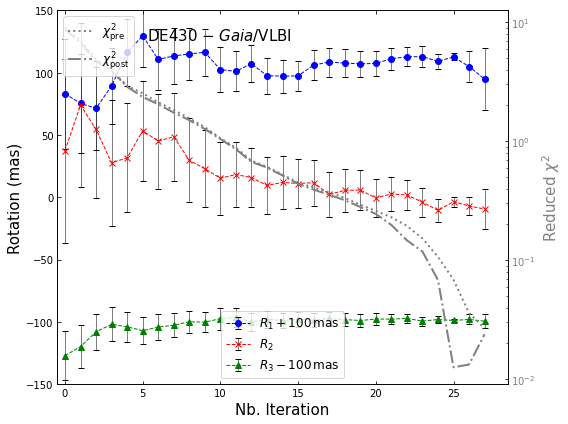

In [81]:
rot_vs_iter(
    pmt430_a,
    sig430_a,
    [-0.5, 28.5, -150, 150],
    apr_chi2=apr_chi2_430_a,
    pst_chi2=pst_chi2_430_a,
    add_text=[0.2, 0.92, "DE430 $-$ $Gaia$/VLBI"],
    xaxis_range=np.arange(0, 30, 5),
    ax_loc="lower center",
    ax1_loc="upper left",
    elw=0.5,
    y_shift=100
)

In [82]:
dra_430, ddec_430 = calc_dpos(gv_timing430, rot430_a)

a_chi2_430, p_chi2_430 = calc_chi2_4_fit(gv_timing430, dra_430, ddec_430)

In [83]:
print("Using all samples, the rotation parameters are")
print("R1:  {:6.3f} +/- {:6.3f} mas".format(rot430[0], iqr430[0]))
print("R2:  {:6.3f} +/- {:6.3f} mas".format(rot430[1], iqr430[2]))
print("R3:  {:6.3f} +/- {:6.3f} mas".format(rot430[2], iqr430[2]))

print("After removing outliers, the rotation parameters are")
print("R1:  {:6.3f} +/- {:6.3f} mas".format(rot430_a[0], iqr430_a[0]))
print("R2:  {:6.3f} +/- {:6.3f} mas".format(rot430_a[1], iqr430_a[2]))
print("R3:  {:6.3f} +/- {:6.3f} mas".format(rot430_a[2], iqr430_a[2]))

Using all samples, the rotation parameters are
R1:   7.192 +/- 10.993 mas
R2:  13.927 +/-  3.503 mas
R3:   0.936 +/-  3.503 mas
After removing outliers, the rotation parameters are
R1:   7.336 +/- 11.209 mas
R2:  11.885 +/-  3.095 mas
R3:   1.177 +/-  3.095 mas


## 3.6 DE436 vs Gaia

In [84]:
# pmt436, sig436, indx, apr_chi2_436, pst_chi2_436 = rot_fit_4_table(
#     gv_timing436)

# rot436, iqr436 = find_pmt_est(pmt436)

# dra_436, ddec_436 = calc_dpos(gv_timing436, rot436)

# a_chi2_436, p_chi2_436 = calc_chi2_4_fit(gv_timing436, dra_436, ddec_436)

In [85]:
# rot_vs_iter(
#     pmt436,
#     sig436,
#     [-0.5, 10.5, -25, 30],
#     apr_chi2=apr_chi2_436,
#     pst_chi2=pst_chi2_436,
#     #     xaxis_range=np.arange(0, 5, 31),
#     add_text=[0.2, 0.92, "DE436 $-$ $Gaia$/VLBI"],
#     ax_loc="lower center",
#     ax1_loc="upper right",
#     elw=0.5,
#     y_shift=10
# )

# 4 Summarize the results

The comparison of formal uncertainties of pulsar positions.

In [86]:
myheaders = ["RA_err_t", "dec_err_t", "pos_err_t",
             "RA_err_g", "dec_err_g", "pos_err_t"]
mystubs = ["DE200", "DE405", "DE421", "DE430", "DE436"]

tbl = SimpleTable(
    pos_err_tab,
    myheaders,
    mystubs,
    title="Positional formal uncertainty for timing and Gaia positions (mas)",
    data_fmts=["%6.2f", "%6.2f", "%6.2f", "%6.2f", "%6.2f", "%6.2f"],
)

print(tbl)

Positional formal uncertainty for timing and Gaia positions (mas)
      RA_err_t dec_err_t pos_err_t RA_err_g dec_err_g pos_err_t
---------------------------------------------------------------
DE200    66.43    165.00    188.23     1.42      1.00      1.76
DE405   747.52    200.00   1058.10     0.87      1.00      1.32
DE421    33.21     70.00     80.83     1.33      1.00      1.66
DE430    69.54    200.00    208.33     1.50      2.00      2.49
DE436      nan       nan       nan      nan       nan       nan
---------------------------------------------------------------


A short table to summarize the orientation between DE frame and Gaia frame.

In [87]:
mydata = [
    [
        nb_psr_200,
        nb_obs_200,
        rot200_a[0],
        iqr200_a[0],
        rot200_a[1],
        iqr200_a[1],
        rot200_a[2],
        iqr200_a[2],
        a_chi2_200,
        p_chi2_200,
    ],
    [
        nb_psr_405,
        nb_obs_405,
        rot405_a[0],
        iqr405_a[0],
        rot405_a[1],
        iqr405_a[1],
        rot405_a[2],
        iqr405_a[2],
        a_chi2_405,
        p_chi2_405,
    ],
    [
        nb_psr_421,
        nb_obs_421,
        rot421_a[0],
        iqr421_a[0],
        rot421_a[1],
        iqr421_a[1],
        rot421_a[2],
        iqr421_a[2],
        a_chi2_421,
        p_chi2_421,
    ],
    [
        nb_psr_430,
        nb_obs_430,
        rot430_a[0],
        iqr430_a[0],
        rot430_a[1],
        iqr430_a[1],
        rot430_a[2],
        iqr430_a[2],
        a_chi2_430,
        p_chi2_430,
    ],
#     [
#         nb_psr_436,
#         nb_obs_436,
#         rot436[0],
#         iqr436[0],
#         rot436[1],
#         iqr436[1],
#         rot436[2],
#         iqr436[2],
#         a_chi2_436,
#         p_chi2_436,
#     ],
]

myheaders = [
    "Nb.PSR",
    "Nb.Obs",
    "R1",
    "R1_err",
    "R2",
    "R2_err",
    "R3",
    "R3_err",
    "ApreFitChi2",
    "PostFitChi2",
]
mystubs = ["DE200", "DE405", "DE421", "DE436"]

tbl = SimpleTable(
    mydata,
    myheaders,
    mystubs,
    title="Orientation of DE frame wrt. Gaia frame (mas)",
    data_fmts=[
        "%d",
        "%d",
        "%6.1f",
        "%6.1f",
        "%6.1f",
        "%6.1f",
        "%6.1f",
        "%6.1f",
        "%6.2f",
        "%6.2f",
    ],
)

print(tbl)

                    Orientation of DE frame wrt. Gaia frame (mas)                    
      Nb.PSR Nb.Obs   R1   R1_err   R2   R2_err   R3   R3_err ApreFitChi2 PostFitChi2
-------------------------------------------------------------------------------------
DE200     58    104    0.8    6.1   -4.4   17.4   -5.3    4.9  1428336.00  1428334.74
DE405     11     11  -35.6   13.0    5.0    5.1  -39.7  131.6       17.43       16.90
DE421     18     20   -4.0   11.7   -3.7   11.7   -0.4    5.4       12.12       12.23
DE436     20     32    7.3   11.2   11.9   20.7    1.2    3.1       14.26       14.29
-------------------------------------------------------------------------------------
